# Descriptive statistics

Make various plots of the data to look for links between categories.

In [1]:
import os
import pandas as pd
import numpy as np  # for NaN

In [2]:
from itertools import product

In [3]:
from scipy.stats import pearsonr

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # for faking a legend

### Import data

In [5]:
dir_files = '../data/organisational_audit/processed'
file_excel = 'processed_2019_portfolio_key_indicators_summary_numeric_shap_admissions.csv'

In [6]:
df = pd.read_csv(os.path.join(dir_files, file_excel), index_col=0)

In [7]:
df = df.drop(['team_samuel', 'stroke_team_id', 'Rank'], axis='columns')

## Names of the Key Indicator columns

In [8]:
cols_ki = [f'ki{i}' for i in range(1, 11)]

In [9]:
ki_group_names = [
    'KI1: nurses per bed',
    'KI2: psychologist',
    'KI3: out-of-hours stroke nurses',
    'KI4: minimum number of nurses',
    'KI5: therapy availability',
    'KI6: pre-alerts',
    'KI7: early supported discharge',
    'KI8: patient and carer survey',
    'KI9: brain imaging type',
    'KI10: leadership'
]

In [10]:
cols_name_dict = dict(zip(cols_ki, ki_group_names))

## Numbers and combinations of Key Indicators met

In [11]:
# How many teams meet each key indicator?
ki_count = []
for col in cols_ki:
    count = df[col].sum(axis=0)
    ki_count.append(count)

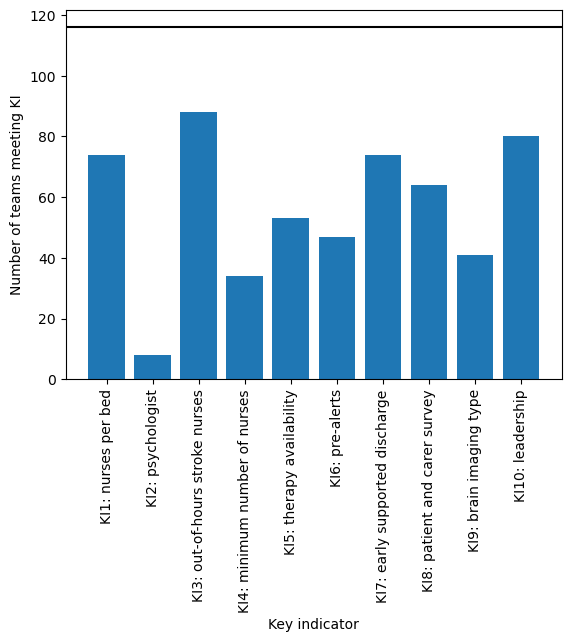

In [12]:
fig, ax = plt.subplots()

ax.bar(np.arange(len(cols_ki)), ki_count)

ax.set_xticks(np.arange(len(cols_ki)))
ax.set_xticklabels(ki_group_names, rotation=90)

ax.set_ylabel('Number of teams meeting KI')
ax.set_xlabel('Key indicator')

ax.axhline(len(df), color='k')

plt.savefig('./images/bar_chart_number_of_teams_each_ki.png', bbox_inches='tight')
plt.show()

Sort the Key Indicator data by number of teams that meet each one:

In [13]:
sort_ki_by_increasingly_met = False

if sort_ki_by_increasingly_met:
    cols = list(df[cols_ki].sum(axis='rows').sort_values(ascending=False).index.values)
else:
    cols = cols_ki

col_names = [cols_name_dict[c] for c in cols]
# Sort dataframe:
df = df.sort_values(['ki_total'] + cols, ascending=False)
# Labels for hospital names:
units = df.index.values


In [14]:
# Find where the number of KIs met changes:
w = np.diff(df['ki_total'])
inds_ki_changes = np.where(w != 0)[0]

# Labels for how many KI were met:
list_total_ki_met = sorted(list(set(df['ki_total'])))[::-1]

inds_ki_changes = np.append(inds_ki_changes, len(df) -1)
list_total_ki_met.append(0)

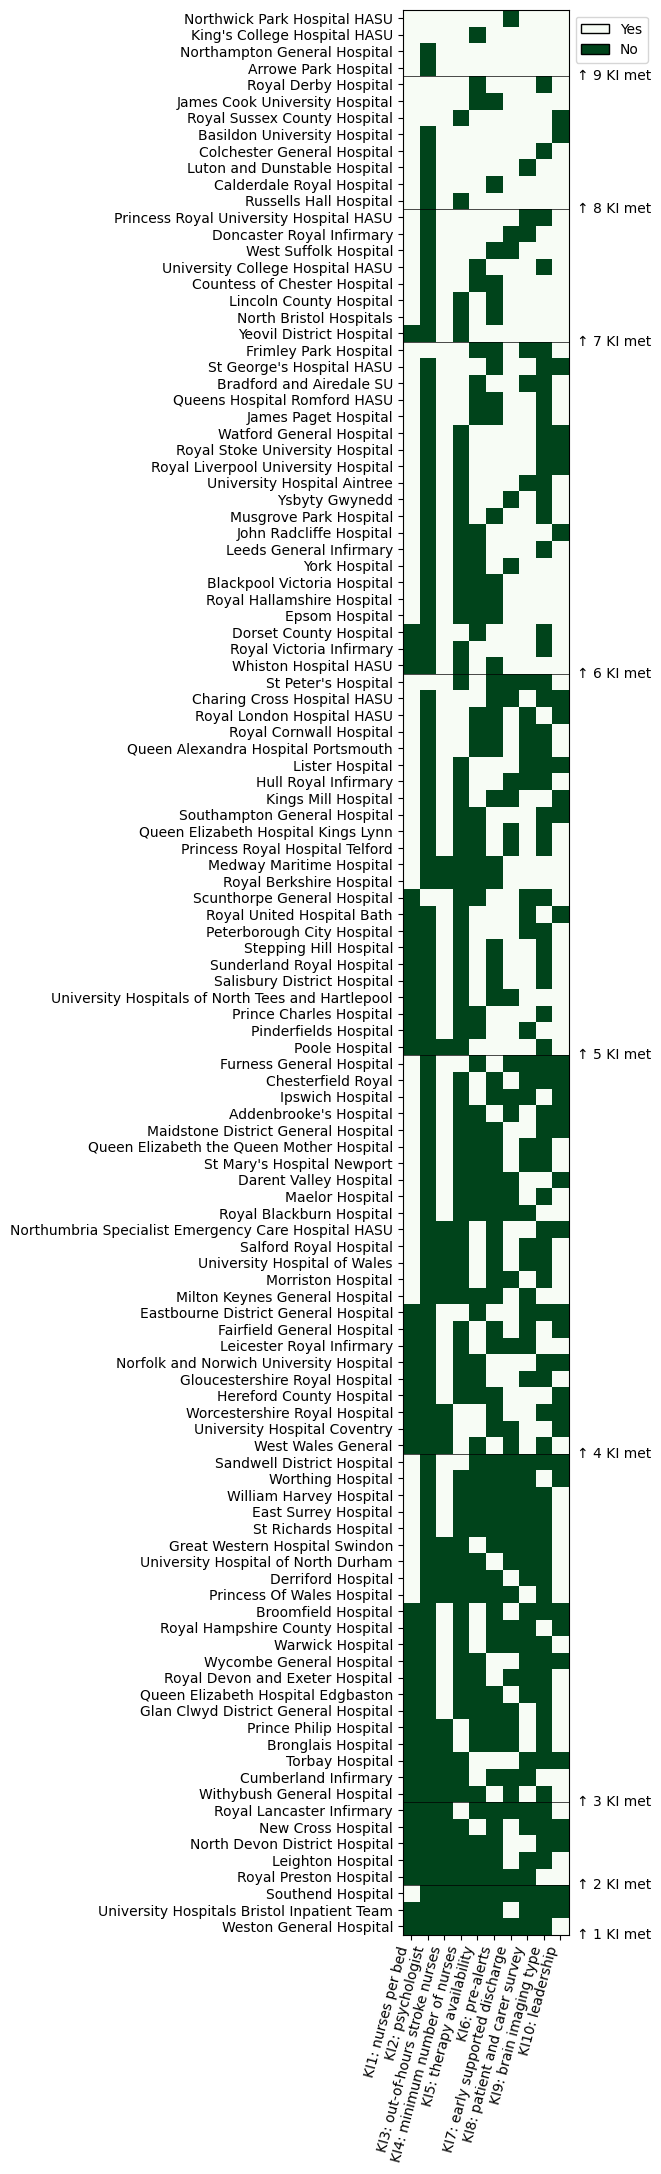

In [15]:
cmap='Greens_r'

fig, ax = plt.subplots(figsize=(10, 25))

c = ax.imshow(df[cols], interpolation='None', cmap=cmap)

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(units)))
ax.set_xticklabels(col_names, rotation=75, ha='right')
ax.set_yticklabels(units)

ax.set_aspect('equal')

for i, x in enumerate(inds_ki_changes):
    ax.axhline(x + 0.5, color='k', linewidth=0.5)
    ax.annotate(f'↑ {list_total_ki_met[i]:.0f} KI met', xy=(len(cols), x+0.5), annotation_clip=False, ha='left', va='center')

patch_yes = mpatches.Patch(facecolor=plt.get_cmap(cmap)(1.0), label='Yes', edgecolor='k')
patch_no = mpatches.Patch(facecolor=plt.get_cmap(cmap)(0.0), label='No', edgecolor='k')
ax.legend(handles=[patch_yes, patch_no], bbox_to_anchor=[1.0, 1.0], loc='upper left')

plt.savefig('./images/heatmap_yes_no_each_team_each_ki.png', bbox_inches='tight')
plt.show()

## Pearson coefficients for only the main key indicators

In [16]:
cols = cols_ki

In [17]:
grid = np.full((len(cols), len(cols)), 0.0)

for c, col_name in enumerate(cols):
    for r, row_name in enumerate(cols):
        if r <= c:
            p = pearsonr(df[col_name], df[row_name])
            grid[c, r] = p.statistic

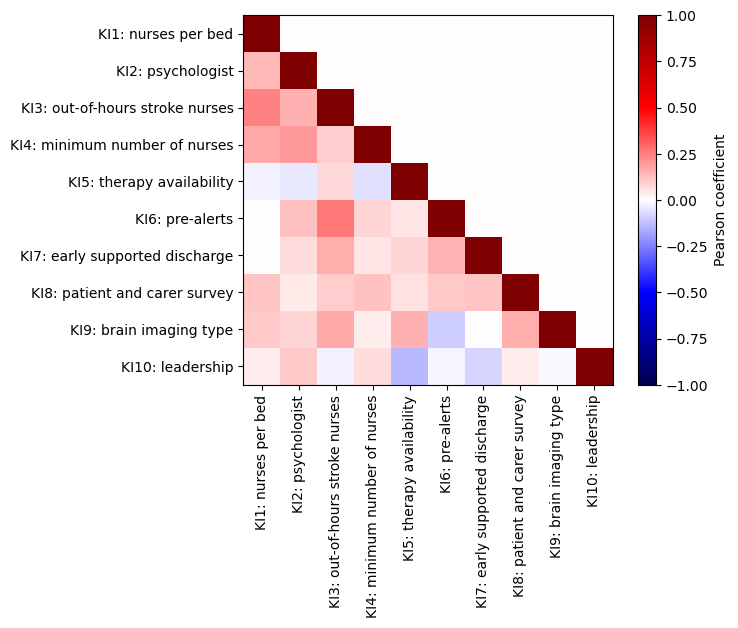

In [18]:
fig, ax = plt.subplots()

c = ax.imshow(grid, vmin=-1.0, vmax=1.0, cmap='seismic')
plt.colorbar(c, label='Pearson coefficient')

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(ki_group_names, rotation=90)
ax.set_yticklabels(ki_group_names)

plt.savefig('./images/heatmap_pearsoncoeff_main_ki.png', bbox_inches='tight')
plt.show()

## Pearson coefficients for everything

This currently excludes the Welsh data where the admissions numbers are missing.

In [19]:
cols = df.columns

# cols = cols_ki

In [20]:
# Remove teams that have no admissions data:
# i.e. **remove Welsh teams**
df = df.dropna()

In [21]:
grid = np.full((len(cols), len(cols)), 0.0)

for c, col_name in enumerate(cols):
    for r, row_name in enumerate(cols):
        if r <= c:
            p = pearsonr(df[col_name], df[row_name])
            grid[c, r] = p.statistic

/home/anna/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [22]:
# Find which Key Indicator each column belongs to:
ki_cols = [col.split('_')[0] for col in cols]
ki_cols = [int(col.split('ki')[-1]) if col.split('ki')[-1].isnumeric() else 0 for col in ki_cols]

# Find where the KI label changes:
w = np.diff(ki_cols)
inds_ki_changes = np.where(w != 0)[0]

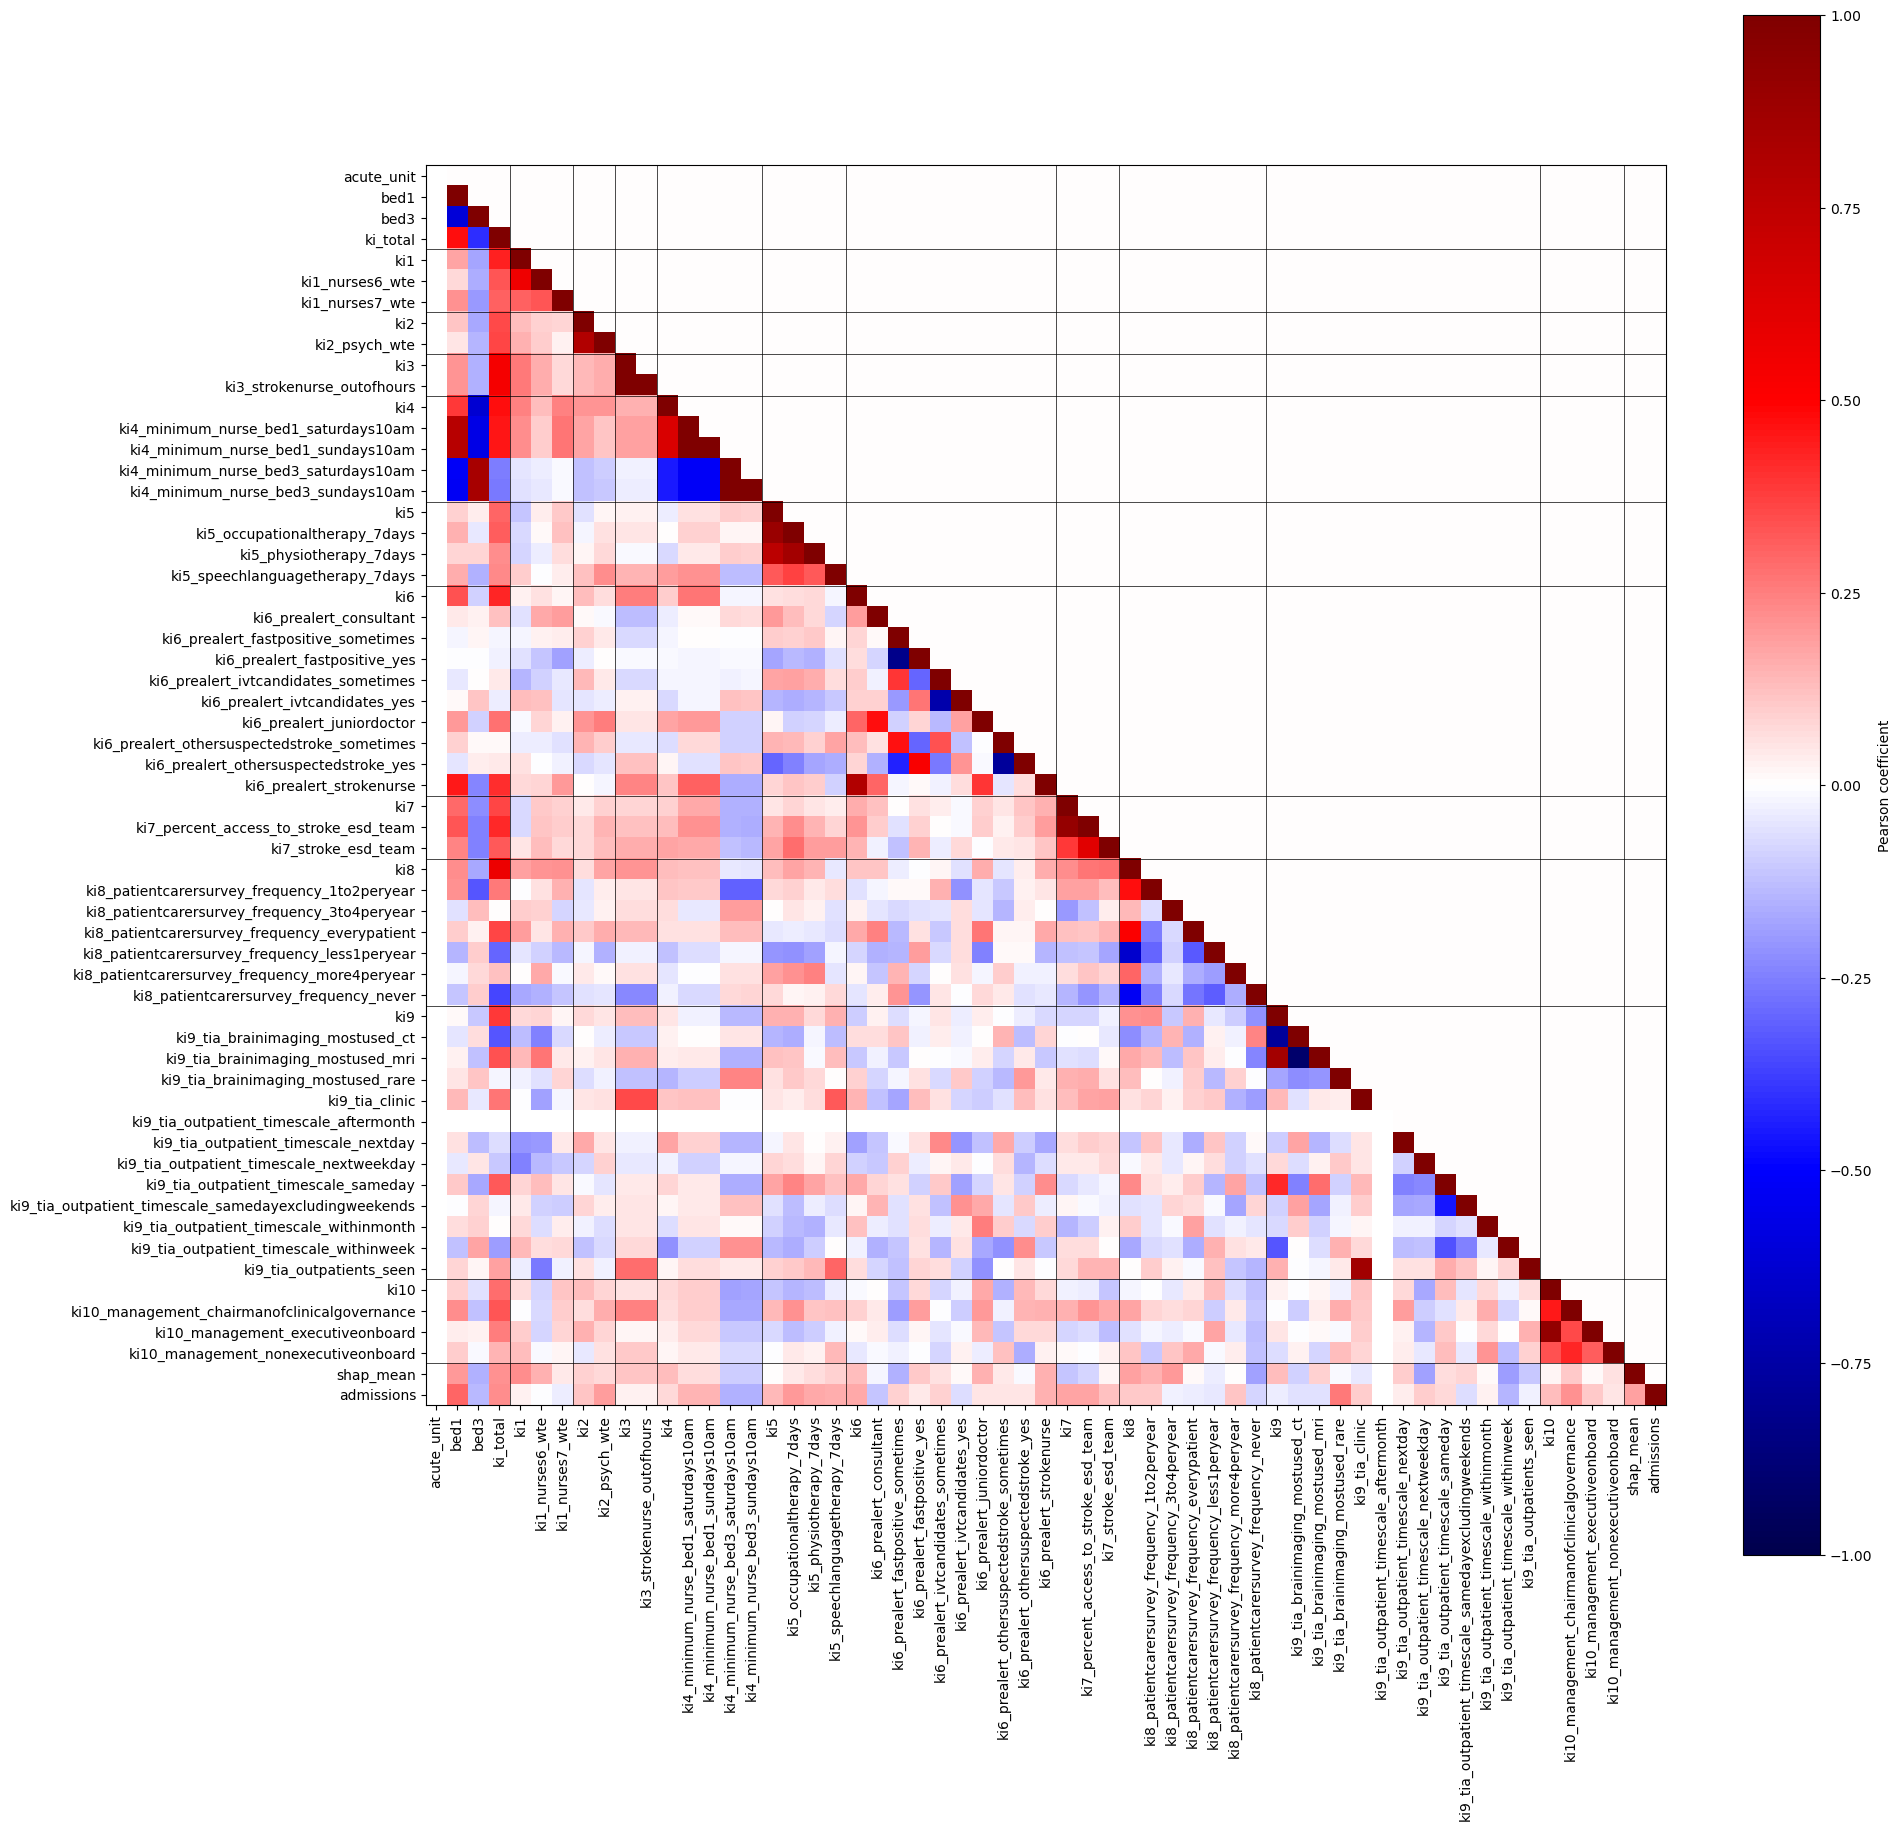

In [23]:
fig, ax = plt.subplots(figsize=(20, 20))

c = ax.imshow(grid, vmin=-1.0, vmax=1.0, cmap='seismic')
plt.colorbar(c, label='Pearson coefficient')

for x in inds_ki_changes:
    # Draw horizontal and vertical line wherever the KI label changes.
    ax.axvline(x + 0.5, color='k', linewidth=0.5)
    ax.axhline(x + 0.5, color='k', linewidth=0.5)

ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=90)
ax.set_yticklabels(cols)

plt.savefig('./images/heatmap_pearsoncoeff_everything.png', bbox_inches='tight')
plt.show()